# Arabic Sentiment Analysis with Azure OpenAI

## Learning Objectives
- Learn to use Azure OpenAI API for sentiment analysis
- Analyze Arabic text sentiment
- Compare AI predictions with ground truth labels
- Visualize sentiment analysis results

## What is Sentiment Analysis?
Sentiment analysis is the process of determining the emotional tone or attitude expressed in text. It classifies text as positive, negative, or neutral, which is valuable for understanding customer feedback, social media monitoring, and business intelligence.


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openai import AzureOpenAI
import time
from collections import Counter

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# ============================================
# AZURE OPENAI API KEY
# ============================================
# API key for Azure OpenAI (configured for Google Colab)
subscription_key = ''


## Step 1: Load and Explore the Data

We'll load the Arabic feedback dataset and examine its structure.


In [8]:
# Load the dataset
df = pd.read_csv('arabic_feedback.csv')

# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

print("\n" + "="*60)
print("Dataset Information")
print("="*60)
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())

print(f"\nDataset info:")
print(df.info())

# Check existing sentiment labels if available
if 'التسمية_المشاعر' in df.columns:
    print(f"\nExisting sentiment label distribution:")
    print(df['التسمية_المشاعر'].value_counts())
    print(f"\nSentiment label percentages:")
    print(df['التسمية_المشاعر'].value_counts(normalize=True) * 100)


First 5 rows of the dataset:
    معرف_المنشور     التاريخ     الوقت اسم_المستخدم  الموقع              فرع  \
0  XT25110231174  2025-11-02  12:55:00          صقر  الدوحة  أبوظبي-الكورنيش   
1  XT25101136365  2025-10-11  17:33:00         محمد     دبي      جدة-السلامة   
2  XT25111041195  2025-11-10  10:14:00        لولوة  أبوظبي        دبي-الخور   
3  XT25102354473  2025-10-23  22:26:00     Bassam_A    تبوك  الرياض-الياسمين   
4  XT25110473092  2025-11-04  09:05:00         شادن    تبوك  أبوظبي-الكورنيش   

  نوع_المنشور                                         نص_المنشور  \
0      اقتباس  تطبيق التوصيل لخبط الطلب من مطعم الطيب، ومحد ر...   
1      اقتباس  الخدمة طبيعية والنظافة جيدة، المقبلات المشكلة ...   
2          رد   مطعم الطيب يقدم خيارات متنوعة. الأسعار متوسطة. 👍   
3      تغريدة  زرت مطعم الطيب اليوم. الشاورما عادي والخدمة مق...   
4          رد  للأسف التجربة سيئة اليوم في مطعم الطيب. تأخير ...   

                                     الوسوم  عدد_الإعجابات  ...  فئة_الموضوع  \
0

## Step 2: Set Up Azure OpenAI Client

Configure the Azure OpenAI client to connect to the API.


In [9]:
# Set up Azure OpenAI client
# The API key is already set in the previous cell

client = AzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://aiproduction6017563007.openai.azure.com/",
    api_key=subscription_key,
)

print("✅ Azure OpenAI client configured successfully!")
print(f"Endpoint: https://aiproduction6017563007.openai.azure.com/")
print(f"API Version: 2024-12-01-preview")
print(f"Model: gpt-4o (default)")
print("\nReady to analyze Arabic sentiment! 🚀")


✅ Azure OpenAI client configured successfully!
Endpoint: https://aiproduction6017563007.openai.azure.com/
API Version: 2024-12-01-preview
Model: gpt-4o (default)

Ready to analyze Arabic sentiment! 🚀


## Step 3: Define Sentiment Analysis Function

Create a function that uses Azure OpenAI to analyze sentiment of Arabic text.


In [10]:
def analyze_sentiment_arabic(text, client, model_name="gpt-4o"):
    """
    Analyze sentiment of Arabic text using Azure OpenAI.
    
    Parameters:
    - text: Arabic text to analyze
    - client: Azure OpenAI client
    - model_name: Name of the model to use
    
    Returns:
    - sentiment: 'positive', 'negative', or 'neutral'
    - confidence: Confidence score (if available)
    """
    
    # Create the prompt for sentiment analysis
    prompt = f"""تحليل المشاعر للنص التالي بالعربية. 
    قم بتصنيف المشاعر إلى: إيجابي، سلبي، أو محايد.
    
    النص:
    {text}
    
    أجب فقط بكلمة واحدة: إيجابي، سلبي، أو محايد"""
    
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "أنت خبير في تحليل المشاعر للنصوص العربية. قم بتحليل المشاعر بدقة."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,  # Lower temperature for more consistent results
            max_tokens=50
        )
        
        result = response.choices[0].message.content.strip()
        
        # Map Arabic responses to English labels
        if 'إيجابي' in result or 'positive' in result.lower():
            return 'positive', 0.9
        elif 'سلبي' in result or 'negative' in result.lower():
            return 'negative', 0.9
        elif 'محايد' in result or 'neutral' in result.lower():
            return 'neutral', 0.9
        else:
            # Default to neutral if unclear
            return 'neutral', 0.5
            
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return 'neutral', 0.0

# Test the function with a sample text
if 'نص_المنشور' in df.columns:
    sample_text = df['نص_المنشور'].iloc[0]
    print(f"Sample text: {sample_text}")
    print("\nNote: Uncomment the line below to test the API (requires valid API key)")
    # sentiment, confidence = analyze_sentiment_arabic(sample_text, client)
    # print(f"Sentiment: {sentiment}, Confidence: {confidence}")


Sample text: تطبيق التوصيل لخبط الطلب من مطعم الطيب، ومحد رد على الاتصالات 😡

Note: Uncomment the line below to test the API (requires valid API key)


In [11]:
# Get the text column (adjust column name if needed)
text_column = 'نص_المنشور'

# Initialize results list
sentiments = []
confidences = []

# Process texts (you can limit the number for testing)
# Set max_samples to None to process all, or a number to limit
max_samples = None  # Change to a number like 10 for testing

texts_to_process = df[text_column].head(max_samples) if max_samples else df[text_column]

print(f"Processing {len(texts_to_process)} texts for sentiment analysis...")
print("This may take several minutes depending on the dataset size.\n")

# Process each text
for idx, text in enumerate(texts_to_process):
    if pd.isna(text) or text.strip() == '':
        sentiments.append('neutral')
        confidences.append(0.0)
        continue
    
    sentiment, confidence = analyze_sentiment_arabic(str(text), client)
    sentiments.append(sentiment)
    confidences.append(confidence)
    
    # Progress update
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1}/{len(texts_to_process)} texts...")
    
    # Small delay to avoid rate limiting
    time.sleep(0.1)

# Add results to dataframe
df['ai_sentiment'] = sentiments
df['ai_confidence'] = confidences

print(f"\n✅ Sentiment analysis complete!")
print(f"Processed {len(sentiments)} texts")


Processing 150 texts for sentiment analysis...
This may take several minutes depending on the dataset size.

Processed 10/150 texts...
Processed 20/150 texts...
Processed 30/150 texts...
Processed 40/150 texts...
Processed 50/150 texts...
Processed 60/150 texts...
Processed 70/150 texts...
Processed 80/150 texts...
Processed 90/150 texts...
Processed 100/150 texts...
Processed 110/150 texts...
Processed 120/150 texts...
Processed 130/150 texts...
Processed 140/150 texts...
Processed 150/150 texts...

✅ Sentiment analysis complete!
Processed 150 texts


In [16]:
df.head()

,معرف_المنشور,التاريخ,الوقت,اسم_المستخدم,الموقع,فرع,نوع_المنشور,نص_المنشور,الوسوم,عدد_الإعجابات,...,جودة_الطعام,سرعة_الخدمة,النظافة,السعر,الجو_العام,خدمة_التوصيل,الجهاز_المستخدم,ai_sentiment,ai_confidence,ground_truth
0,XT25110231174,2025-11-02,12:55:00,صقر,الدوحة,أبوظبي-الكورنيش,اقتباس,تطبيق التوصيل لخبط الطلب من مطعم الطيب، ومحد ر...,#غداء #أكل #الدوحة #أجواء,47,...,1,1,1,1,1,2,iPhone,negative,0.9,negative
1,XT25101136365,2025-10-11,17:33:00,محمد,دبي,جدة-السلامة,اقتباس,الخدمة طبيعية والنظافة جيدة، المقبلات المشكلة ...,#أكل #غداء #مطاعم #عشاء #دبي #حلال #خدمة,19,...,3,3,3,3,3,3,iPhone,neutral,0.9,neutral
2,XT25111041195,2025-11-10,10:14:00,لولوة,أبوظبي,دبي-الخور,رد,مطعم الطيب يقدم خيارات متنوعة. الأسعار متوسطة. 👍,#تقييم #أكل #نظافة,6,...,3,3,3,3,3,3,iPhone,positive,0.9,neutral
3,XT25102354473,2025-10-23,22:26:00,Bassam_A,تبوك,الرياض-الياسمين,تغريدة,زرت مطعم الطيب اليوم. الشاورما عادي والخدمة مق...,#تجربة #الأسعار #حلال #تبوك #الطيب,19,...,3,3,3,3,3,3,iPhone,neutral,0.9,neutral
4,XT25110473092,2025-11-04,09:05:00,شادن,تبوك,أبوظبي-الكورنيش,رد,للأسف التجربة سيئة اليوم في مطعم الطيب. تأخير ...,#نظافة #غداء #حلال #تقييم #تبوك,53,...,2,2,2,1,1,2,iPhone,negative,0.9,negative


## Step 5: Analyze Results

Let's examine the sentiment analysis results and compare with ground truth labels if available.


In [12]:
# Display sentiment distribution
print("="*60)
print("AI SENTIMENT ANALYSIS RESULTS")
print("="*60)

print(f"\nSentiment Distribution:")
sentiment_counts = pd.Series(sentiments).value_counts()
print(sentiment_counts)
print(f"\nSentiment Percentages:")
print(pd.Series(sentiments).value_counts(normalize=True) * 100)

print(f"\nAverage Confidence: {np.mean(confidences):.3f}")
print(f"Confidence Range: {np.min(confidences):.3f} - {np.max(confidences):.3f}")

# Compare with ground truth if available
if 'التسمية_المشاعر' in df.columns:
    print("\n" + "="*60)
    print("COMPARISON WITH GROUND TRUTH")
    print("="*60)
    
    # Map Arabic labels to English
    label_mapping = {
        'إيجابي': 'positive',
        'سلبي': 'negative',
        'محايد': 'neutral'
    }
    
    df['ground_truth'] = df['التسمية_المشاعر'].map(label_mapping)
    
    # Create comparison
    comparison = pd.crosstab(df['ground_truth'], df['ai_sentiment'], margins=True)
    print("\nConfusion Matrix (Ground Truth vs AI Prediction):")
    print(comparison)
    
    # Calculate accuracy
    accuracy = (df['ground_truth'] == df['ai_sentiment']).mean()
    print(f"\nAccuracy: {accuracy:.2%}")
    
    # Show some examples
    print("\n" + "="*60)
    print("SAMPLE PREDICTIONS")
    print("="*60)
    sample_df = df[['نص_المنشور', 'ground_truth', 'ai_sentiment', 'ai_confidence']].head(10)
    for idx, row in sample_df.iterrows():
        print(f"\nText: {row['نص_المنشور'][:50]}...")
        print(f"Ground Truth: {row['ground_truth']}, AI Prediction: {row['ai_sentiment']}, Confidence: {row['ai_confidence']:.2f}")


AI SENTIMENT ANALYSIS RESULTS

Sentiment Distribution:
negative    52
neutral     49
positive    49
Name: count, dtype: int64

Sentiment Percentages:
negative    34.666667
neutral     32.666667
positive    32.666667
Name: proportion, dtype: float64

Average Confidence: 0.900
Confidence Range: 0.900 - 0.900

COMPARISON WITH GROUND TRUTH

Confusion Matrix (Ground Truth vs AI Prediction):
ai_sentiment  negative  neutral  positive  All
ground_truth                                  
negative            50        0         0   50
neutral              2       47         1   50
positive             0        2        48   50
All                 52       49        49  150

Accuracy: 96.67%

SAMPLE PREDICTIONS

Text: تطبيق التوصيل لخبط الطلب من مطعم الطيب، ومحد رد عل...
Ground Truth: negative, AI Prediction: negative, Confidence: 0.90

Text: الخدمة طبيعية والنظافة جيدة، المقبلات المشكلة يحتا...
Ground Truth: neutral, AI Prediction: neutral, Confidence: 0.90

Text: مطعم الطيب يقدم خيارات متنوعة. ا

## Step 6: Visualize Results

Create visualizations to understand the sentiment analysis results.


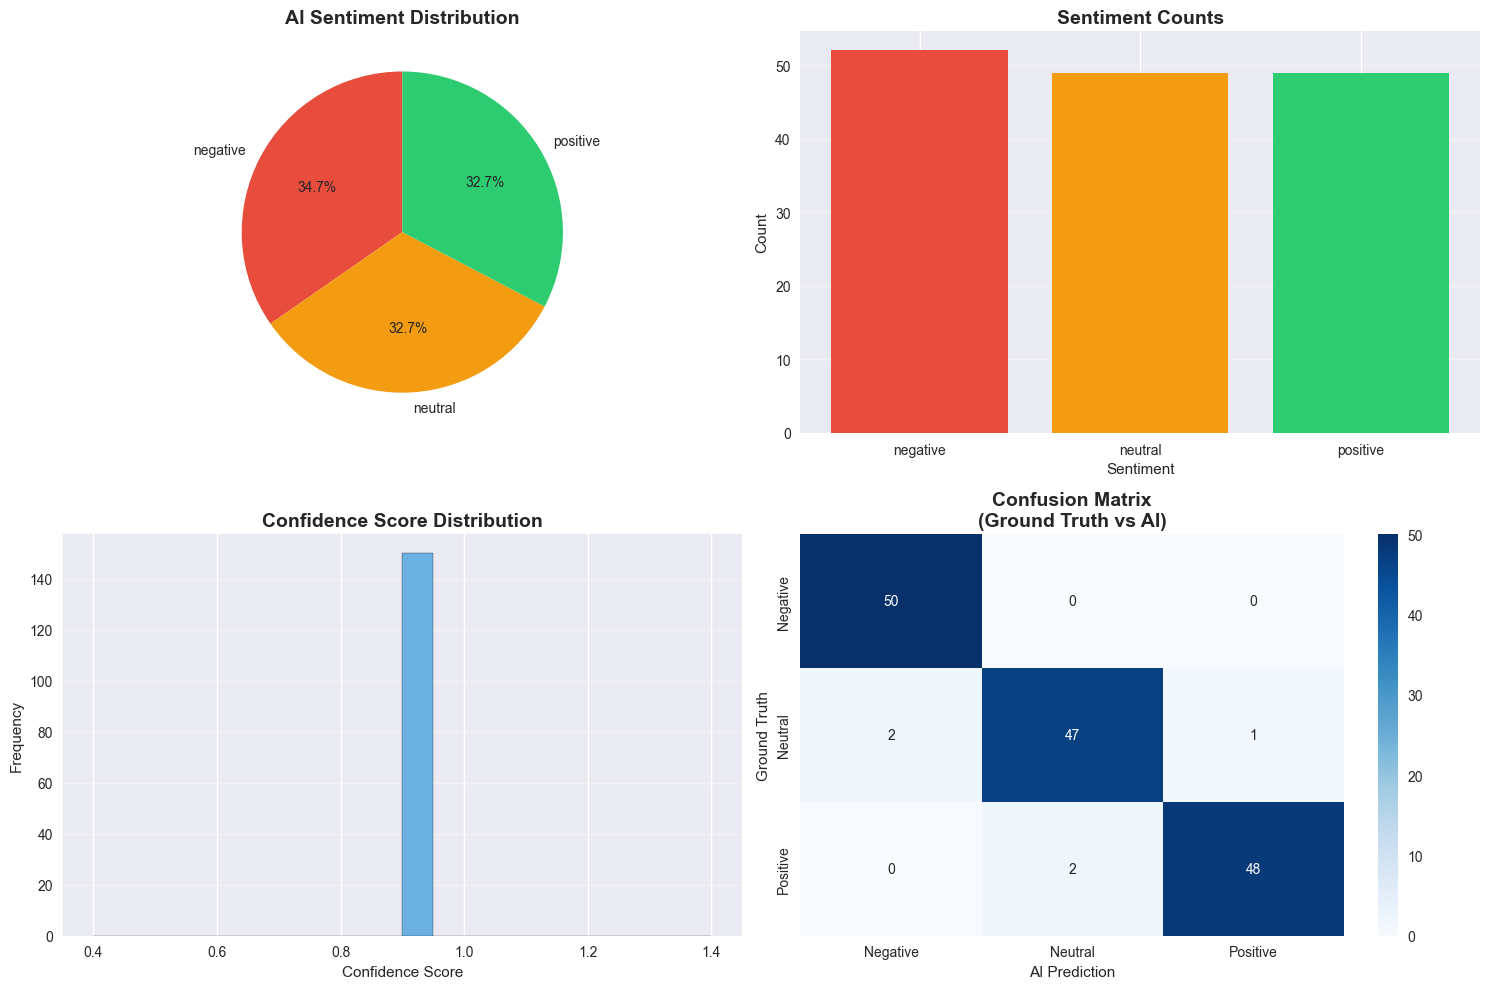

In [13]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Sentiment Distribution (Pie Chart)
sentiment_counts = pd.Series(sentiments).value_counts()
colors = {'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#f39c12'}
pie_colors = [colors.get(s, '#95a5a6') for s in sentiment_counts.index]

axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
               colors=pie_colors, startangle=90)
axes[0, 0].set_title('AI Sentiment Distribution', fontsize=14, fontweight='bold')

# Plot 2: Sentiment Distribution (Bar Chart)
axes[0, 1].bar(sentiment_counts.index, sentiment_counts.values, 
               color=[colors.get(s, '#95a5a6') for s in sentiment_counts.index])
axes[0, 1].set_title('Sentiment Counts', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Confidence Distribution
axes[1, 0].hist(confidences, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Confidence Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Comparison with Ground Truth (if available)
if 'ground_truth' in df.columns:
    comparison_data = pd.crosstab(df['ground_truth'], df['ai_sentiment'])
    sns.heatmap(comparison_data, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[1, 1].set_title('Confusion Matrix\n(Ground Truth vs AI)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('AI Prediction')
    axes[1, 1].set_ylabel('Ground Truth')
else:
    # Show confidence by sentiment
    df_plot = pd.DataFrame({'sentiment': sentiments, 'confidence': confidences})
    sns.boxplot(data=df_plot, x='sentiment', y='confidence', ax=axes[1, 1],
                palette=[colors.get(s, '#95a5a6') for s in df_plot['sentiment'].unique()])
    axes[1, 1].set_title('Confidence by Sentiment', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Sentiment')
    axes[1, 1].set_ylabel('Confidence Score')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Step 7: Save Results

Save the results with AI sentiment predictions to a new CSV file.


In [14]:
# Save results to a new CSV file
output_filename = 'arabic_feedback_with_sentiment.csv'

# Select relevant columns to save
columns_to_save = ['نص_المنشور', 'ai_sentiment', 'ai_confidence']

# Add ground truth if available
if 'ground_truth' in df.columns:
    columns_to_save.insert(1, 'ground_truth')

# Add other useful columns if they exist
useful_cols = ['معرف_المنشور', 'التاريخ', 'اسم_المستخدم', 'الموقع', 'فرع']
for col in useful_cols:
    if col in df.columns:
        columns_to_save.append(col)

# Save to CSV
df[columns_to_save].to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"✅ Results saved to '{output_filename}'")
print(f"\nSaved columns: {columns_to_save}")
print(f"\nFirst few rows of saved file:")
print(df[columns_to_save].head())


✅ Results saved to 'arabic_feedback_with_sentiment.csv'

Saved columns: ['نص_المنشور', 'ground_truth', 'ai_sentiment', 'ai_confidence', 'معرف_المنشور', 'التاريخ', 'اسم_المستخدم', 'الموقع', 'فرع']

First few rows of saved file:
                                          نص_المنشور ground_truth  \
0  تطبيق التوصيل لخبط الطلب من مطعم الطيب، ومحد ر...     negative   
1  الخدمة طبيعية والنظافة جيدة، المقبلات المشكلة ...      neutral   
2   مطعم الطيب يقدم خيارات متنوعة. الأسعار متوسطة. 👍      neutral   
3  زرت مطعم الطيب اليوم. الشاورما عادي والخدمة مق...      neutral   
4  للأسف التجربة سيئة اليوم في مطعم الطيب. تأخير ...     negative   

  ai_sentiment  ai_confidence   معرف_المنشور     التاريخ اسم_المستخدم  الموقع  \
0     negative            0.9  XT25110231174  2025-11-02          صقر  الدوحة   
1      neutral            0.9  XT25101136365  2025-10-11         محمد     دبي   
2     positive            0.9  XT25111041195  2025-11-10        لولوة  أبوظبي   
3      neutral            0.9  XT2

## Step 8: Detailed Analysis Examples

Let's examine some specific examples to understand the model's performance better.


In [15]:
# Analyze examples by sentiment
print("="*60)
print("DETAILED EXAMPLES BY SENTIMENT")
print("="*60)

for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_df = df[df['ai_sentiment'] == sentiment]
    if len(sentiment_df) > 0:
        print(f"\n{'='*60}")
        print(f"{sentiment.upper()} SENTIMENT EXAMPLES")
        print(f"{'='*60}")
        
        # Show top 3 examples
        examples = sentiment_df.nlargest(3, 'ai_confidence')[['نص_المنشور', 'ai_sentiment', 'ai_confidence']]
        
        for idx, row in examples.iterrows():
            print(f"\nExample {idx}:")
            print(f"Text: {row['نص_المنشور']}")
            print(f"Sentiment: {row['ai_sentiment']}, Confidence: {row['ai_confidence']:.2f}")
            
            if 'ground_truth' in df.columns:
                print(f"Ground Truth: {row.get('ground_truth', 'N/A')}")

# Show misclassifications if ground truth is available
if 'ground_truth' in df.columns:
    print("\n" + "="*60)
    print("MISCLASSIFICATIONS")
    print("="*60)
    
    misclassified = df[df['ground_truth'] != df['ai_sentiment']]
    print(f"Number of misclassifications: {len(misclassified)}")
    
    if len(misclassified) > 0:
        print("\nSample misclassifications:")
        for idx, row in misclassified.head(5).iterrows():
            print(f"\nText: {row['نص_المنشور'][:80]}...")
            print(f"Ground Truth: {row['ground_truth']}, AI Prediction: {row['ai_sentiment']}")


DETAILED EXAMPLES BY SENTIMENT

POSITIVE SENTIMENT EXAMPLES

Example 2:
Text: مطعم الطيب يقدم خيارات متنوعة. الأسعار متوسطة. 👍
Sentiment: positive, Confidence: 0.90
Ground Truth: N/A

Example 7:
Text: خدمة راقية وابتسامة من الموظفين في مطعم الطيب. الكباب كان ممتاز 👍
Sentiment: positive, Confidence: 0.90
Ground Truth: N/A

Example 8:
Text: أول زيارة لـ مطعم الطيب وكانت فوق التوقعات. السمك المشوي يستاهل التجربة 👌
Sentiment: positive, Confidence: 0.90
Ground Truth: N/A

NEGATIVE SENTIMENT EXAMPLES

Example 0:
Text: تطبيق التوصيل لخبط الطلب من مطعم الطيب، ومحد رد على الاتصالات 😡
Sentiment: negative, Confidence: 0.90
Ground Truth: N/A

Example 4:
Text: للأسف التجربة سيئة اليوم في مطعم الطيب. تأخير كبير والطلب وصل بارد 😞
Sentiment: negative, Confidence: 0.90
Ground Truth: N/A

Example 5:
Text: للأسف التجربة سيئة اليوم في مطعم الطيب. تأخير كبير والطلب وصل بارد 😞
Sentiment: negative, Confidence: 0.90
Ground Truth: N/A

NEUTRAL SENTIMENT EXAMPLES

Example 1:
Text: الخدمة طبيعية والنظافة جيدة، ا

## Key Takeaways

1. **Azure OpenAI** provides powerful language models for sentiment analysis
2. **Arabic text** can be effectively analyzed using GPT models
3. **Sentiment classification** helps understand customer feedback at scale
4. **Confidence scores** indicate model certainty in predictions
5. **Ground truth comparison** helps evaluate model performance
6. **Batch processing** with rate limiting is important for API calls

## Best Practices

- **Rate Limiting**: Add delays between API calls to avoid hitting rate limits
- **Error Handling**: Always include try-except blocks for API calls
- **Cost Management**: Consider processing in batches or sampling for large datasets
- **Model Selection**: Choose appropriate models based on accuracy vs cost trade-offs
- **Prompt Engineering**: Well-crafted prompts improve accuracy

## Practice Exercise

1. Try modifying the prompt to get more detailed sentiment analysis (e.g., include intensity scores)
2. Experiment with different temperature values to see how it affects consistency
3. Compare results using different models (if available)
4. Add error handling for network issues and retry logic
